In [133]:
%load_ext autoreload
%autoreload 2

In [183]:
from sklearn.linear_model import SGDRegressor
from random import sample
from functools import lru_cache
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

from sklearn.datasets import make_classification
from sklearn.preprocessing import minmax_scale
from scipy.stats import truncnorm
from scipy.stats import skewnorm

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

from utils import ServiceParams, vectorize_for_bonus_predict, vectorize_for_neighbours_predict

import pickle

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

In [140]:
train_dataset_len = 1000
test_dataset_len = 500

(array([32., 50., 78., 52., 76., 40., 80., 45., 40., 71., 37., 59., 26.,
        51., 22., 32., 18., 19., 28., 21., 31.,  7., 15., 11.,  7., 14.,
         6.,  9.,  3.,  4.,  1.,  4.,  2.,  2.,  4.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([18.  , 19.44, 20.88, 22.32, 23.76, 25.2 , 26.64, 28.08, 29.52,
        30.96, 32.4 , 33.84, 35.28, 36.72, 38.16, 39.6 , 41.04, 42.48,
        43.92, 45.36, 46.8 , 48.24, 49.68, 51.12, 52.56, 54.  , 55.44,
        56.88, 58.32, 59.76, 61.2 , 62.64, 64.08, 65.52, 66.96, 68.4 ,
        69.84, 71.28, 72.72, 74.16, 75.6 , 77.04, 78.48, 79.92, 81.36,
        82.8 , 84.24, 85.68, 87.12, 88.56, 90.  ]),
 <BarContainer object of 50 artists>)

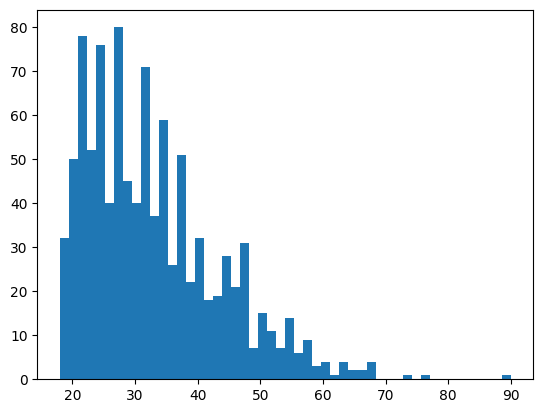

In [164]:
skewness = 30

age = skewnorm.rvs(a = skewness, size=train_dataset_len)
age = minmax_scale(age, feature_range=(18, 90))
age = age.round()
df_train = pd.DataFrame(age, columns=['age'])

age = skewnorm.rvs(a = skewness, size=test_dataset_len)
age = minmax_scale(age, feature_range=(18, 90))
age = age.round()
df_test = pd.DataFrame(age, columns=['age'])

plt.hist(df_train.age, bins=50)

In [67]:
# Service engage type
merchant_mcc_and_description = [
    "Electronics: Products such as smartphones, laptops, tablets, TVs, and gaming consoles",
    "Fashion: Clothing, shoes, handbags, accessories, and jewelry",
    "Beauty and personal care: Makeup, skincare, haircare, and grooming products",
    "Home and kitchen: Appliances, furniture, home decor, and cookware",
    "Sports and fitness: Athletic clothing, equipment, and supplements",
    "Toys and games: Board games, puzzles, action figures, and dolls",
    "Books and media: Fiction and non-fiction books, magazines, and DVDs",
    "Food and beverages: Snacks, drinks, and packaged foods",
    "Health and wellness: Vitamins, supplements, and medical devices",
    "Automotive: Cars, motorcycles, bicycles, and accessories",
    "Pet supplies: Products such as food, toys, and accessories for dogs, cats, and other pets",
    "Office supplies: Stationery, printers, and office furniture",
    "Music: Instruments, sheet music, and audio equipment",
    "Travel and leisure: Luggage, travel accessories, and camping gear",
    "Art and crafts: Supplies for drawing, painting, and crafting",
    "Garden and outdoor: Tools, planters, and outdoor furniture",
    "Baby and kids: Clothing, toys, and baby gear",
    "Industrial and scientific: Laboratory equipment, machinery, and scientific instruments",
    "Party supplies: Decorations, party favors, and supplies for hosting events",
    "Education and learning: Products such as textbooks, online courses, educational toys, and educational software for learners of all ages"
]

merchant_mcc = ['electronics',
 'fashion',
 'beauty and personal care',
 'home and kitchen',
 'sports and fitness',
 'toys and games',
 'books and media',
 'food and beverages',
 'health and wellness',
 'automotive',
 'pet supplies',
 'office supplies',
 'music',
 'travel and leisure',
 'art and crafts',
 'garden and outdoor',
 'baby and kids',
 'industrial and scientific',
 'party supplies',
 'education and learning']

bonus_type = [
    'welcome',
    'loyalty',
    'discount',
    'cashback',
    'up-sell',
    'gift',
    'early-access',
]

merchant_id_to_amount_range = {
    0: ['electronics', range(50, 10_000)],
    1: ['fashion', range(10, 10_000)],
    2: ['beauty and personal care', range(5, 500)],
    3: ['home and kitchen', range(10, 20_000)],
    4: ['sports and fitness', range(5, 5_000)],
    5: ['toys and games', range(5, 1000)],
    6: ['books and media', range(5, 1000)],
    7: ['food and beverages', range(1, 100)],
    8: ['health and wellness', range(5, 1000)],
    9: ['automotive', range(5_000, 100_000)],
    10: ['pet supplies', range(5, 1000)],
    11: ['office supplies', range(1, 10_000)],
    12: ['music', range(50, 10_000)],
    13: ['travel and leisure', range(50, 10_000)],
    14: ['art and crafts', range(5, 1000)],
    15: ['garden and outdoor', range(10, 20_000)],
    16: ['baby and kids', range(5, 1_000)],
    17: ['industrial and scientific', range(10, 100_000)],
    18: ['party supplies', range(5, 1_000)],
    19: ['education and learning', range(10, 10_000)]
 }

id2merchantName = { i : desc for i, desc in enumerate(merchant_mcc) }
merchantName2id = { desc : i for i, desc in enumerate(merchant_mcc) }
id2bonusName = { i : desc for i, desc in enumerate(bonus_type) }
bonusName2id = { desc : i for i, desc in enumerate(bonus_type) }
id2merchantName

{0: 'electronics',
 1: 'fashion',
 2: 'beauty and personal care',
 3: 'home and kitchen',
 4: 'sports and fitness',
 5: 'toys and games',
 6: 'books and media',
 7: 'food and beverages',
 8: 'health and wellness',
 9: 'automotive',
 10: 'pet supplies',
 11: 'office supplies',
 12: 'music',
 13: 'travel and leisure',
 14: 'art and crafts',
 15: 'garden and outdoor',
 16: 'baby and kids',
 17: 'industrial and scientific',
 18: 'party supplies',
 19: 'education and learning'}

In [6]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [171]:
number_of_stores = 1000
merchants_df = pd.DataFrame(index=range(0,number_of_stores), columns=['merchant_mcc', 'bonuses_available'])
def generate_random_stores(row):
    row['merchant_mcc'] = sample(merchant_mcc, 1)[0]
    row['bonuses_available'] = sample(bonus_type, random.randint(0, len(bonus_type)))
    return row
    
merchants_df = merchants_df.apply(generate_random_stores, axis=1)
merchants_df

,merchant_mcc,bonuses_available
0,beauty and personal care,"[welcome, cashback, discount, loyalty, early-a..."
1,beauty and personal care,[]
2,books and media,"[cashback, early-access]"
3,automotive,"[welcome, discount]"
4,garden and outdoor,"[gift, discount, up-sell, loyalty, cashback, w..."
...,...,...
995,art and crafts,[discount]
996,home and kitchen,"[early-access, welcome, loyalty, discount, gif..."
997,art and crafts,[]
998,garden and outdoor,"[cashback, welcome, discount, early-access, lo..."


In [177]:
# Purchase history generation {purchase_type, amount} random purchase_type, random amount
min_number_purchase = 0
max_number_purchase = 50
min_amount_bonus_points_available = 0
max_amount_bonus_points_available = 99_999_999
min_amount_assets_available = 0
max_amount_assets_available = 99_999_999
min_number_transactions = 0
max_number_transactions = 99_999_999

random_rating = get_truncated_normal(mean=10, sd=2, low=1, upp=5).rvs(train_dataset_len)

def generate_purchase_history(row, train=True):
    number_of_purchases = np.random.randint(min_number_purchase, max_number_purchase, 1)[0]
    purchase_preferences = np.random.randint(0, len(merchant_id_to_amount_range), 1)[0] 
    truncated_normal = get_truncated_normal(mean=purchase_preferences, sd=2, low=0, upp=len(merchant_id_to_amount_range)-1)
    indices = truncated_normal.rvs(number_of_purchases).round()
    current_merchant_id = random.randint(0, number_of_stores-1)
    current_merchant = merchants_df.iloc[current_merchant_id]
    bonuses_available = current_merchant.bonuses_available
    purchase_history = []
    purchase_history_names = []
    rating = random_rating[row.name]
    for purchase_id in indices:
        purchase_name, range = merchant_id_to_amount_range[purchase_id]
        purchase_history.append([purchase_name, np.around(np.random.uniform(range[0], range[-1]+1, 1), 1)[0]])
        purchase_history_names.append(purchase_name)
    row['purchase_history'] = purchase_history
    row['rating'] = rating
    if train:
        row['current_merchant_id'] = current_merchant_id
        if len(bonuses_available) > 0 and rating >= np.random.uniform(1.0, 5.0):
            bonuse_to_offer = sample(bonuses_available, 1)[0]
        else:
            bonuse_to_offer = ''
        row['bonus_to_offer'] = bonuse_to_offer
    return row


df_train = df_train.apply(generate_purchase_history, axis = 1)
df_test = df_test.apply(generate_purchase_history, train=False, axis = 1)
df_train

,age,purchase_history,rating
0,35.0,"[[home and kitchen, 6314.1], [beauty and perso...",4.293411
1,22.0,"[[music, 7862.0], [food and beverages, 70.5], ...",3.911830
2,38.0,"[[travel and leisure, 5433.2], [books and medi...",4.016069
3,27.0,"[[office supplies, 5468.8], [office supplies, ...",4.704216
4,64.0,"[[travel and leisure, 737.4], [health and well...",4.437198
...,...,...,...
495,38.0,"[[automotive, 28758.3], [office supplies, 7840...",4.994387
496,26.0,"[[books and media, 181.8], [pet supplies, 480....",4.756006
497,27.0,"[[food and beverages, 82.1], [toys and games, ...",4.825468
498,38.0,"[[home and kitchen, 12946.9], [sports and fitn...",4.899437


In [159]:
service_params = ServiceParams(
    max_number_purchase = max_number_purchase,
    bonus_type = bonus_type,
    merchantName2id = merchantName2id,
    bonusName2id = bonusName2id,
)

In [174]:
vectors =  np.array(df_train.apply(vectorize_for_bonus_predict, merchant_id=None, merchants_db=merchants_df, params=service_params, axis=1).to_list())
X = vectors[:,:-1].astype(np.float32)
y = vectors[:,-1].astype(np.int32)
X, y

(array([[2.9000000e+01, 5.0000000e+00, 7.3199997e+01, ..., 0.0000000e+00,
         0.0000000e+00, 4.4627419e+00],
        [2.1000000e+01, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 4.8610063e+00],
        [3.1000000e+01, 7.0000000e+00, 4.0570001e+02, ..., 2.0000000e+00,
         6.0000000e+00, 4.7938547e+00],
        ...,
        [3.0000000e+01, 5.0000000e+00, 3.1558999e+03, ..., 0.0000000e+00,
         0.0000000e+00, 4.9571681e+00],
        [2.9000000e+01, 7.0000000e+00, 1.6900000e+02, ..., 0.0000000e+00,
         0.0000000e+00, 4.7550583e+00],
        [2.9000000e+01, 1.3000000e+01, 5.2631001e+03, ..., 0.0000000e+00,
         0.0000000e+00, 4.4609714e+00]], dtype=float32),
 array([4, 1, 2, 6, 4, 5, 3, 1, 0, 0, 1, 0, 7, 2, 2, 0, 3, 2, 1, 7, 0, 3,
        7, 7, 5, 6, 1, 3, 0, 5, 1, 3, 1, 0, 0, 1, 2, 0, 6, 1, 0, 0, 0, 7,
        4, 1, 0, 4, 0, 2, 6, 7, 1, 5, 2, 5, 3, 4, 0, 7, 5, 5, 5, 7, 4, 2,
        2, 0, 3, 0, 4, 4, 0, 6, 1, 6, 4, 3, 0, 0, 0, 1, 0, 2, 7,

In [175]:
gbc_clf = GradientBoostingClassifier(verbose=1)
gbc_clf.fit(X, y)

      Iter       Train Loss   Remaining Time 
         1           1.9011           15.63s
         2           1.8120           14.23s
         3           1.7481           13.65s
         4           1.6869           13.17s
         5           1.6322           12.19s
         6           1.5839           11.50s
         7           1.5409           11.06s
         8           1.5007           10.67s
         9           1.4677           10.33s
        10           1.4351           10.24s
        20           1.2161            8.41s
        30           1.0516            7.22s
        40           0.9095            6.10s
        50           0.7934            5.05s
        60           0.6899            4.00s
        70           0.6059            3.00s
        80           0.5367            1.97s
        90           0.4750            0.98s
       100           0.4205            0.00s


GradientBoostingClassifier(verbose=1)

In [178]:
gbc_clf.predict_proba(X[5:10]).argmax(axis=1)

array([5, 3, 1, 0, 0])

In [186]:
vectors =  np.array(df_train.apply(vectorize_for_neighbours_predict, params=service_params, axis=1).to_list())
X = vectors.astype(np.float32)
X

array([[2.9000000e+01, 1.5000000e+01, 8.9770001e+02, ..., 0.0000000e+00,
        0.0000000e+00, 4.2934113e+00],
       [2.1000000e+01, 1.2000000e+01, 6.9591001e+03, ..., 0.0000000e+00,
        0.0000000e+00, 3.9118299e+00],
       [3.1000000e+01, 1.9000000e+01, 5.2159998e+02, ..., 0.0000000e+00,
        0.0000000e+00, 4.0160694e+00],
       ...,
       [3.0000000e+01, 1.2000000e+01, 3.4820000e+03, ..., 0.0000000e+00,
        0.0000000e+00, 4.1674123e+00],
       [2.9000000e+01, 1.4000000e+01, 7.8482998e+03, ..., 0.0000000e+00,
        0.0000000e+00, 3.3899386e+00],
       [2.9000000e+01, 1.3000000e+01, 5.0647002e+03, ..., 0.0000000e+00,
        0.0000000e+00, 4.6465640e+00]], dtype=float32)

In [191]:
nbrs_clf = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nbrs_clf.fit(X)

NearestNeighbors(algorithm='ball_tree')

In [190]:
distances, indices = nbrs_clf.kneighbors(X[:1])
nearest = df_train.iloc[indices[0]]
nearest, distances

NotFittedError: This NearestNeighbors instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [182]:
# Import models and data for inference

gbc_filename = 'data/gbc.clf'
nbrs_filename = 'data/nbrs.clf'
service_params_filename = 'data/service.params'
pickle.dump(gbc_clf, open(gbc_filename, 'wb'))
pickle.dump(nbrs_clf, open(nbrs_filename, 'wb'))
pickle.dump(service_params, open(service_params_filename, 'wb'))
df_train.to_csv('data/train_db.csv', index=False)
df_test.to_csv('data/test_db.csv', index=False)
merchants_df.to_csv('data/merchants_db.csv', index=False)